# 6. PyTorch Transfer Learning

What is transfer learining?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model = foundation models

In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.3.1
0.18.1


Now we have got the versions of torch and torchvision, we are after, let us import the code we have written in previous sections so that we do not have to write again

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

from going_modular import data_setup, engine


In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
!nvidia-smi

Sun Oct 13 16:49:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:2D:00.0  On |                  N/A |
|  0%   47C    P8             21W /  240W |    1305MiB /   8192MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data

we need our pizza, steak, sushi data to build a transfer model

In [6]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists, skipping redownload")
else:
    print(f"Did not find {image_path}, downloading it")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak and sushi data
    with open(data_path / "pizza_steak_sushi", 'wb') as f:
        requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(requests.content)

    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")



data\pizza_steak_sushi directory exists, skipping redownload


In [7]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now we have got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function.

There is one thing we have to think about when loading: how to **transorm** it?

There is 2 ways to do it:
1. Manually created transforms
2. Automatically created transforms

When using a pretrained model, it is important that the data(including your custom data) that you pass through it **transformed** in the same way that the data the model was trained on

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right with `torchvision`.

In [8]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229, 0.224,0.225])
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)), # resize image to 224, 224 (height x width)
    transforms.ToTensor(), # get images into range [0,1]
    normalize # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)
])

In [9]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names =  data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1ac4dda9640>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` there is now support for automatic data transform creation based on pretrained model weights you are using

In [10]:
import torchvision
torchvision.__version__

'0.18.1'

In [11]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [21]:
# Create Dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=auto_transforms, batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1ac4e091160>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get pretrained model, such as:
1. PyTorch domain libraries
2. Libraries lime `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment*

The whole idea of transfer learning: take an already well performing model from a problem  space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed
2. Size
3. Performance

Where does the model live?
is it on device?

For our case, it looks like EffNetB0 is one of our best options in terms performance vs size

However, In light of the bitter lesson, if we had infinite compute, we would likely pick the biggest model + most performace + most general we could

### 3.2 Setting up a pretrained model

Want to create an instance of pretrained model EffNetB0-
https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0

In [14]:
# Old method of creating a pretrained model
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a  pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT = best available weight"
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

 ### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [16]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224), #(batch_size, color_channels, height, width)
        col_names=["input_size","output_size", "num_params", "trainable"],
        row_settings=['var_names']
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of pretrained/foundation model and update the output layers to suit your own problem.

In [25]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Update the classifier head of our model to suit our problem
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
                in_features=1280, # feature vector coming in
                out_features=len(class_names)
              )
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [26]:
summary(model=model,
        input_size=(1,3,224,224), #(batch_size, color_channels, height, width)
        col_names=["input_size","output_size", "num_params", "trainable"],
        row_settings=['var_names']
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

## 4. Training our feature extraction model

In [28]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
# Import train fn
from going_modular import engine

# Set manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn= loss_fn, epochs=5,
                        device=device
                        )

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.2339 | Train acc: 0.9225 | Test loss: 0.2185 | Test acc:0.9207
Epoch: 1 | Train loss: 0.2190 | Train acc: 0.9358 | Test loss: 0.2149 | Test acc:0.9231
Epoch: 2 | Train loss: 0.2133 | Train acc: 0.9294 | Test loss: 0.2130 | Test acc:0.9207
Epoch: 3 | Train loss: 0.2070 | Train acc: 0.9319 | Test loss: 0.2009 | Test acc:0.9255
Epoch: 4 | Train loss: 0.1925 | Train acc: 0.9341 | Test loss: 0.2032 | Test acc:0.9183
[INFO] Total training time: 198.824 seconds


## 5.Evaluate model by plotting loss curves

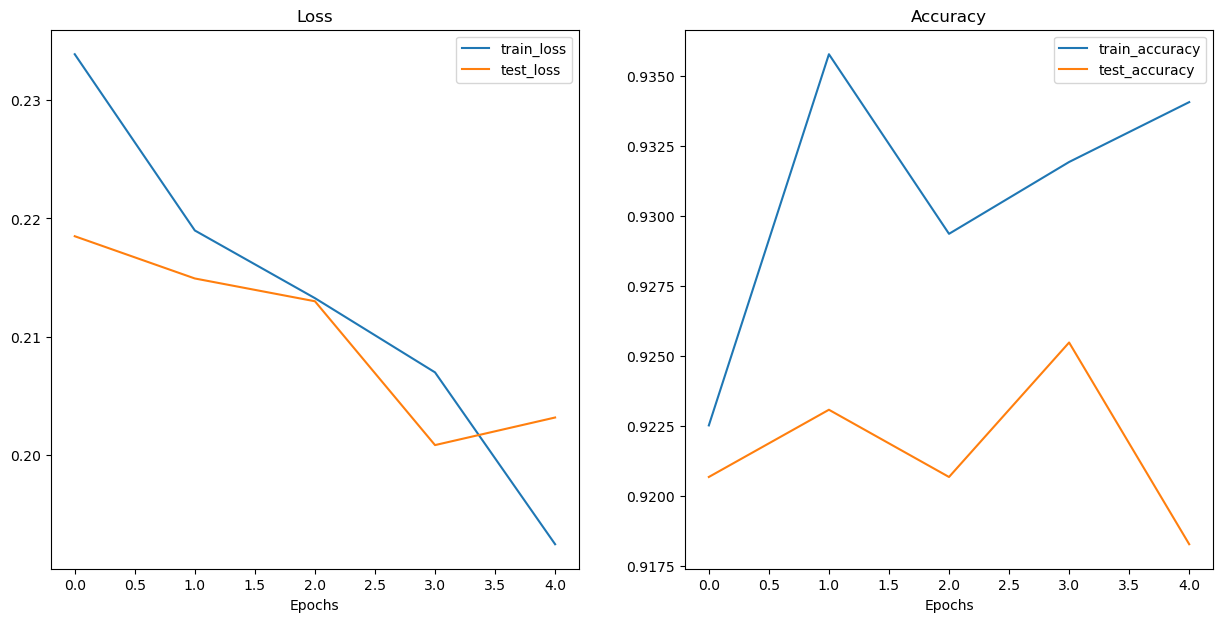

In [32]:

from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 6. Make predictions on images from the test set

Some things to keep in mind when making predictions/inference to test data/custom data.

We have to make sure that our test/custom data is:

* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you have transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automatically, let us create a function calld `pred_and_plot_image`

The function will be similar to the one in chapter 4

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure  the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it is ready for inference (this will turn off `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model
7. Make a prediction on the image by passing to the model
8. Convert the model output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image  with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8

In [48]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in trained model
def pred_and_plot_image(
        model: torch.nn.Module,
        image_path: str,
        class_names: List[str],
        image_size: Tuple[int, int] = (224, 224),
        transform: torchvision.transforms=None,
        device: torch.device=device
        ):
    # 2. Open image with PIL
    img = Image.open(image_path)

    # 3. Create a transform if one does not exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])

    ### Predict on Image ###
    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6.Transform the image and add an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

        # 7. Make a prediction on the transformed image by passing it to the model (also make sure it is on target device)
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert the model's out put logits to pred_probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert the model pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

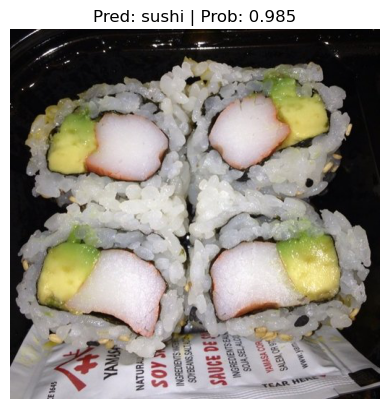

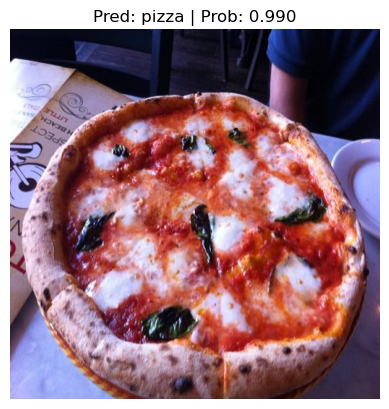

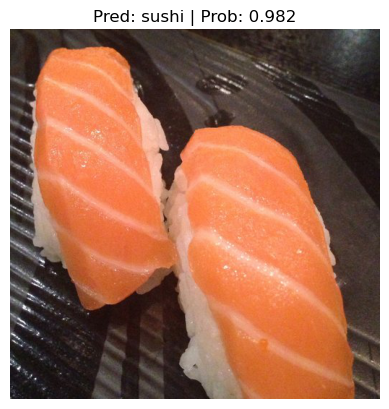

In [53]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, image_path=image_path, class_names=class_names, image_size=(224,224))

### 6.1 Making predictions on a custom image

In [54]:
# Download the iamge
import requests

custom_image_path = data_path / f"{random.randint(1,100000)}-image.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # Download image from GitHub with raw link
        request =requests.get("https://cdn.apartmenttherapy.info/image/upload/v1558445248/k/archive/cb2e9502cd9da3468caa944e15527b19bce68a8e.jpg")
        print(f"Download {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download")

Download data\82361-image.jpeg...


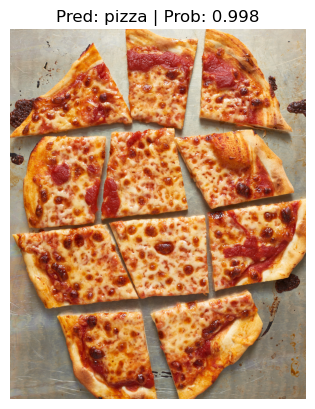

In [55]:
# Predict on custom image
pred_and_plot_image(model=model, image_path= custom_image_path, class_names=class_names)